In [22]:
!git clone https://github.com/anushka-s/Image-restoration-using-deep-image-prior.git
!mv Image-restoration-using-deep-image-prior/* ./

fatal: destination path 'Image-restoration-using-deep-image-prior' already exists and is not an empty directory.
mv: cannot stat 'Image-restoration-using-deep-image-prior/*': No such file or directory


In [79]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [80]:
## denoising
fname = '/content/data/denoising/F16_GT.png'

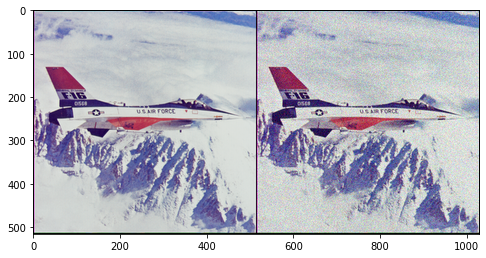

In [81]:
if fname == '/content/data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [83]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.001

OPTIMIZER= 'adam'
show_every = 100
exp_weight=0.99

if fname == '/content/data/denoising/F16_GT.png':
    num_iter = 1000
    input_depth = 3
    figsize = 3 
    
    
    net = ResNet(input_depth, figsize, 128, 3, norm_layer=nn.BatchNorm2d).to(device)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach().to(device)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype).to(device)

Number of params: 22530


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.




After 0 iterations: 
Iteration 00000    Loss 0.098585   PSNR_noisy: 10.061897   PSRN_gt: 10.447827   PSNR_gt_sm: 10.447827 


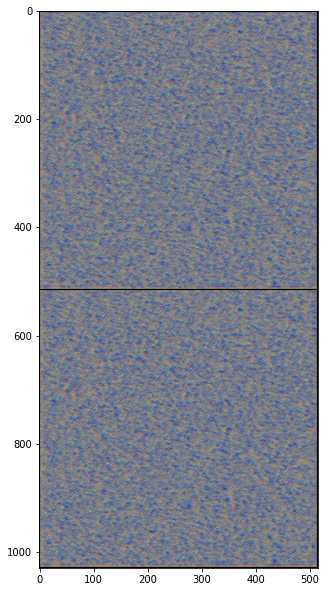



After 100 iterations: 
Iteration 00100    Loss 0.053671   PSNR_noisy: 12.702572   PSRN_gt: 13.458824   PSNR_gt_sm: 11.620839 


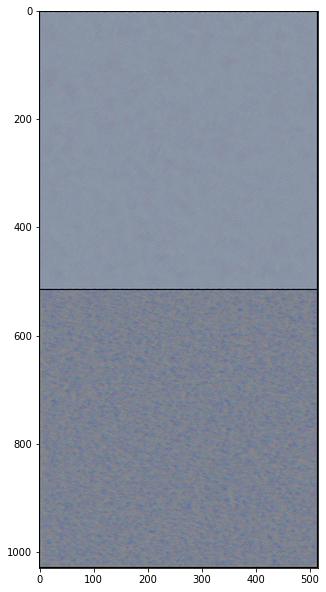



After 200 iterations: 
Iteration 00200    Loss 0.037349   PSNR_noisy: 14.277180   PSRN_gt: 15.459503   PSNR_gt_sm: 14.238712 


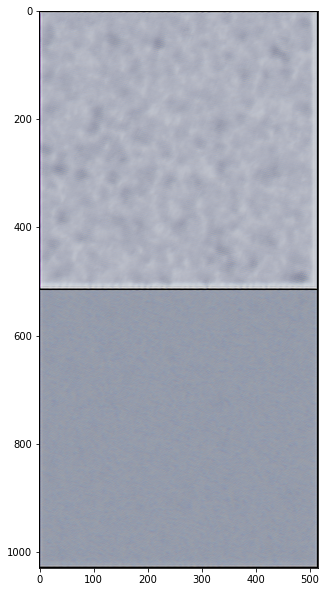



After 300 iterations: 
Iteration 00300    Loss 0.035944   PSNR_noisy: 14.443703   PSRN_gt: 15.683890   PSNR_gt_sm: 15.404590 


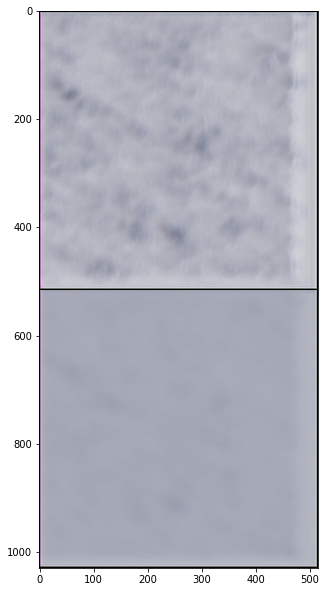



After 400 iterations: 
Iteration 00400    Loss 0.032891   PSNR_noisy: 14.829234   PSRN_gt: 16.206880   PSNR_gt_sm: 15.926009 


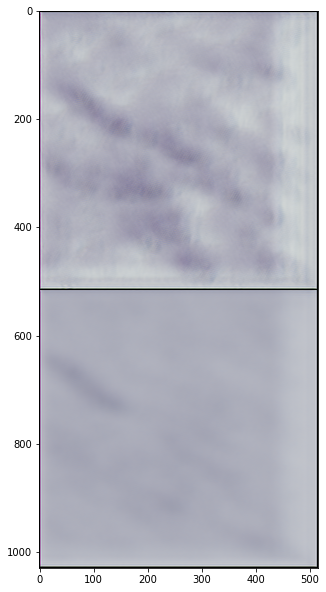



After 500 iterations: 
Iteration 00500    Loss 0.032150   PSNR_noisy: 14.928190   PSRN_gt: 16.354206   PSNR_gt_sm: 16.404017 


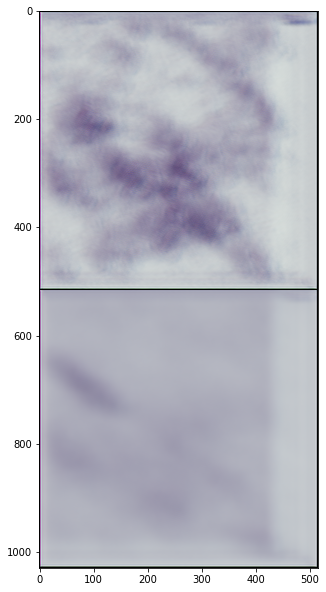



After 600 iterations: 
Iteration 00600    Loss 0.032159   PSNR_noisy: 14.926996   PSRN_gt: 16.347920   PSNR_gt_sm: 16.830211 


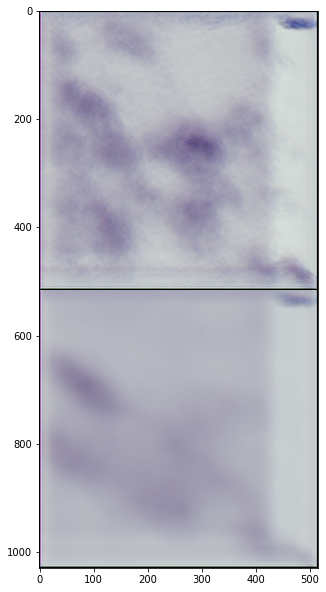



After 700 iterations: 
Iteration 00700    Loss 0.030156   PSNR_noisy: 15.206235   PSRN_gt: 16.744230   PSNR_gt_sm: 17.162288 


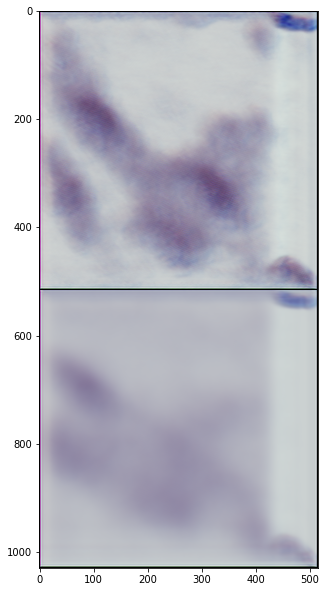



After 800 iterations: 
Iteration 00800    Loss 0.028770   PSNR_noisy: 15.410532   PSRN_gt: 17.037242   PSNR_gt_sm: 17.398446 


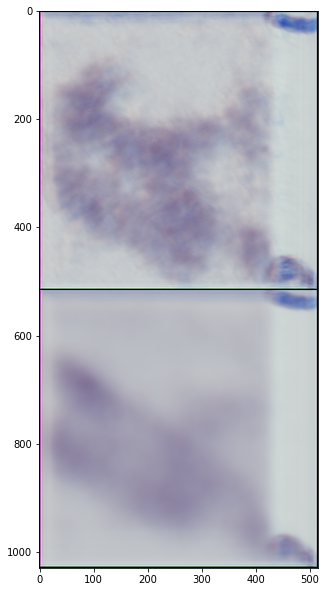



After 900 iterations: 
Iteration 00900    Loss 0.028618   PSNR_noisy: 15.433597   PSRN_gt: 17.070597   PSNR_gt_sm: 17.539985 


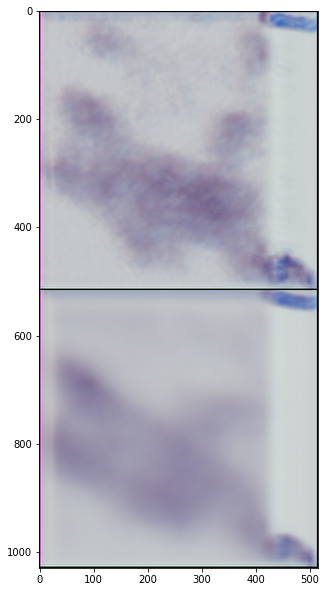

In [84]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
loss = []

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, loss
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std) #changing the input to the netwok
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight) # calculating average network output
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    loss.append(total_loss.item())
        
    
    # caculating psrn
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the actual noisy image 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) # comparing psnr for the output image and the original image 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) # comparing psnr for the output average and the original image 
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        # plotting the output image along the average image calculated
        print(f'\n\nAfter {i} iterations: ')
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f   PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='\n')
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

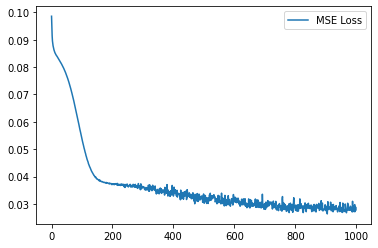

In [85]:
# Plotting the loss as a function of number of iterations
itr = [i for i in range(num_iter)]
plt.plot(itr, loss, )
plt.legend(['MSE Loss'])
plt.show()

Output Image from the network: 


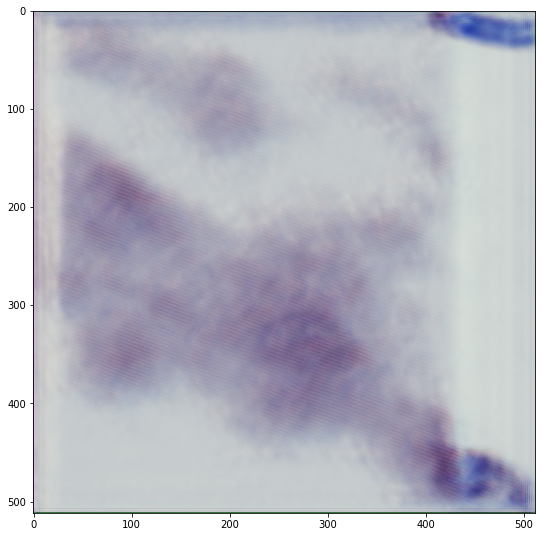


Noised Image: 


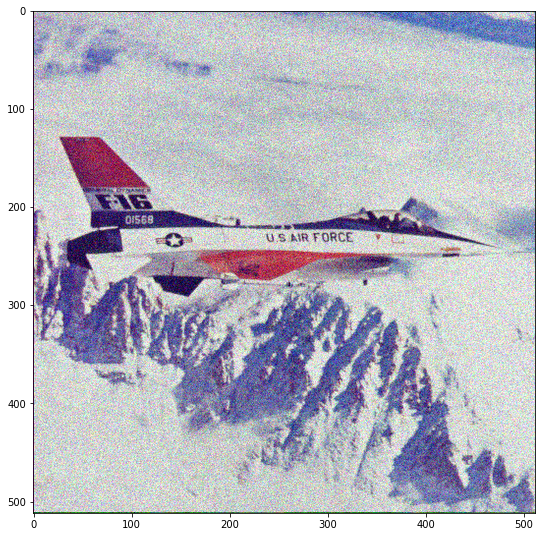


Original Image: 


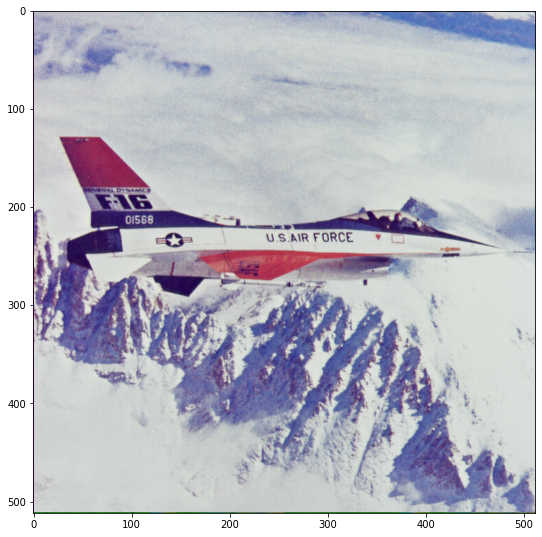

In [86]:
out_np = torch_to_np(net(net_input))

print('Output Image from the network: ')
plot_image_grid([np.clip(out_np, 0, 1)], factor=8);

print('\nNoised Image: ')
plot_image_grid([img_noisy_np], factor=8);

print('\nOriginal Image: ')
plot_image_grid([img_np], factor=8);